# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

# Check devices
print(f"mps available: {torch.backends.mps.is_available()}")
print(f"mps built: {torch.backends.mps.is_built()}")
print(f"cuda available: {torch.cuda.is_available()}")

mps available: False
mps built: False
cuda available: False


## MVP Environment

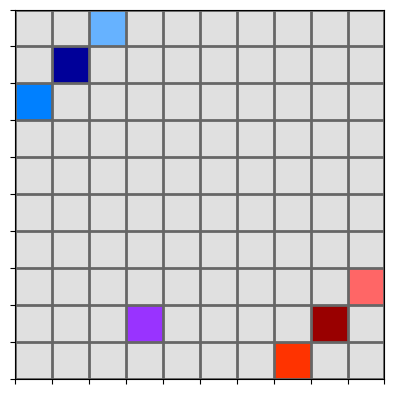

In [2]:
# instantiate environment
env = GridworldCtf(game_mode='static')
env.render()

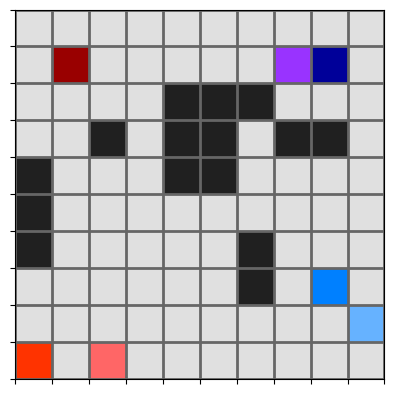

In [3]:
env = GridworldCtf(game_mode='random')
env.render()

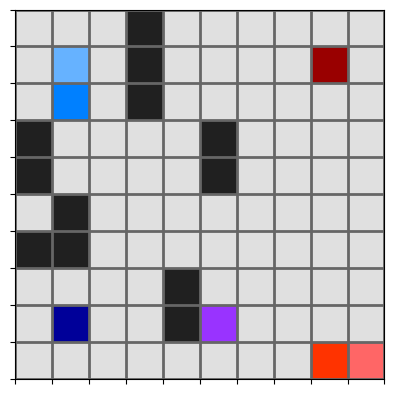

Move 0
Game exited


In [4]:
# playing against random agents
env.ENABLE_PICKUPS = True
env.AGENT_TYPES = {
    0: 2,
    1: 0,
    2: 0,
    3: 0
}
env.reset()
env.play(player=0)

In [5]:
env.get_env_metadata(0)

array([1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 1.    ,
       2.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 1.5   , 0.6665, 0.6665, 0.6665], dtype=float16)

In [6]:
env.metrics

{'team_points': {0: 0, 1: 0},
 'tag_count': {0: 0, 1: 0},
 'agent_tag_count': defaultdict(int, {}),
 'agent_flag_captures': defaultdict(int, {}),
 'agent_blocks_laid': defaultdict(int, {}),
 'agent_blocks_mined': defaultdict(int, {}),
 'agent_total_distance_to_own_flag': defaultdict(int, {}),
 'agent_total_distance_to_opp_flag': defaultdict(int, {}),
 'agent_health_pickups': defaultdict(int, {})}

In [6]:
env.get_standardised_state(0, n_channels=1)

array([[[ 20,   0,  10,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  90,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  60,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  60,   0,   0,   0,  60,  60],
        [  0,   0,   0, 110,  60,  60,  60,   0,   0,   0],
        [  0,   0,   0,   0,   0,  60,  60,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, -20,   0,   0,  60,  60,   0,   0, 100,   0],
        [  0, -20,   0,   0,   0,   0,   0,   0,   0,   0]]], dtype=int8)

## Deep Q-Network

### Train agents - Flag carriers only

In [6]:
# create environment
env = GridworldCtf(game_mode='random')
env.ENABLE_PICKUPS = True
device = "cpu"
env.AGENT_TYPES = {
    0: 0,
    1: 2,
    2: 0,
    3: 2
}

# configure agents
n_actions = 4
batch_size = 32
gamma = 0.9
lr = 0.000025
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
use_softmax = True
loss = 'mse'

agent_t1 = DQNAgent(name='dqn_t1',
                    n_actions=n_actions,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss)

agent_t2 = DQNAgent(name='dqn_t2',
                    n_actions=n_actions,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                env_dims=(1, 1, 10, 10),
                                epochs=50,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                device='cpu')

episode: 46                 
total step count: 26373                 
episode step count: 1001                 
score: -4004                 
average score: -2210.695652173913                 
epsilon: 0.956                 
done count: 38                 
team 1 captures: 22                 
team 2 captures: 16


In [7]:
# save models
agent_t1.save_model()
agent_t2.save_model()

#### Performance metrics

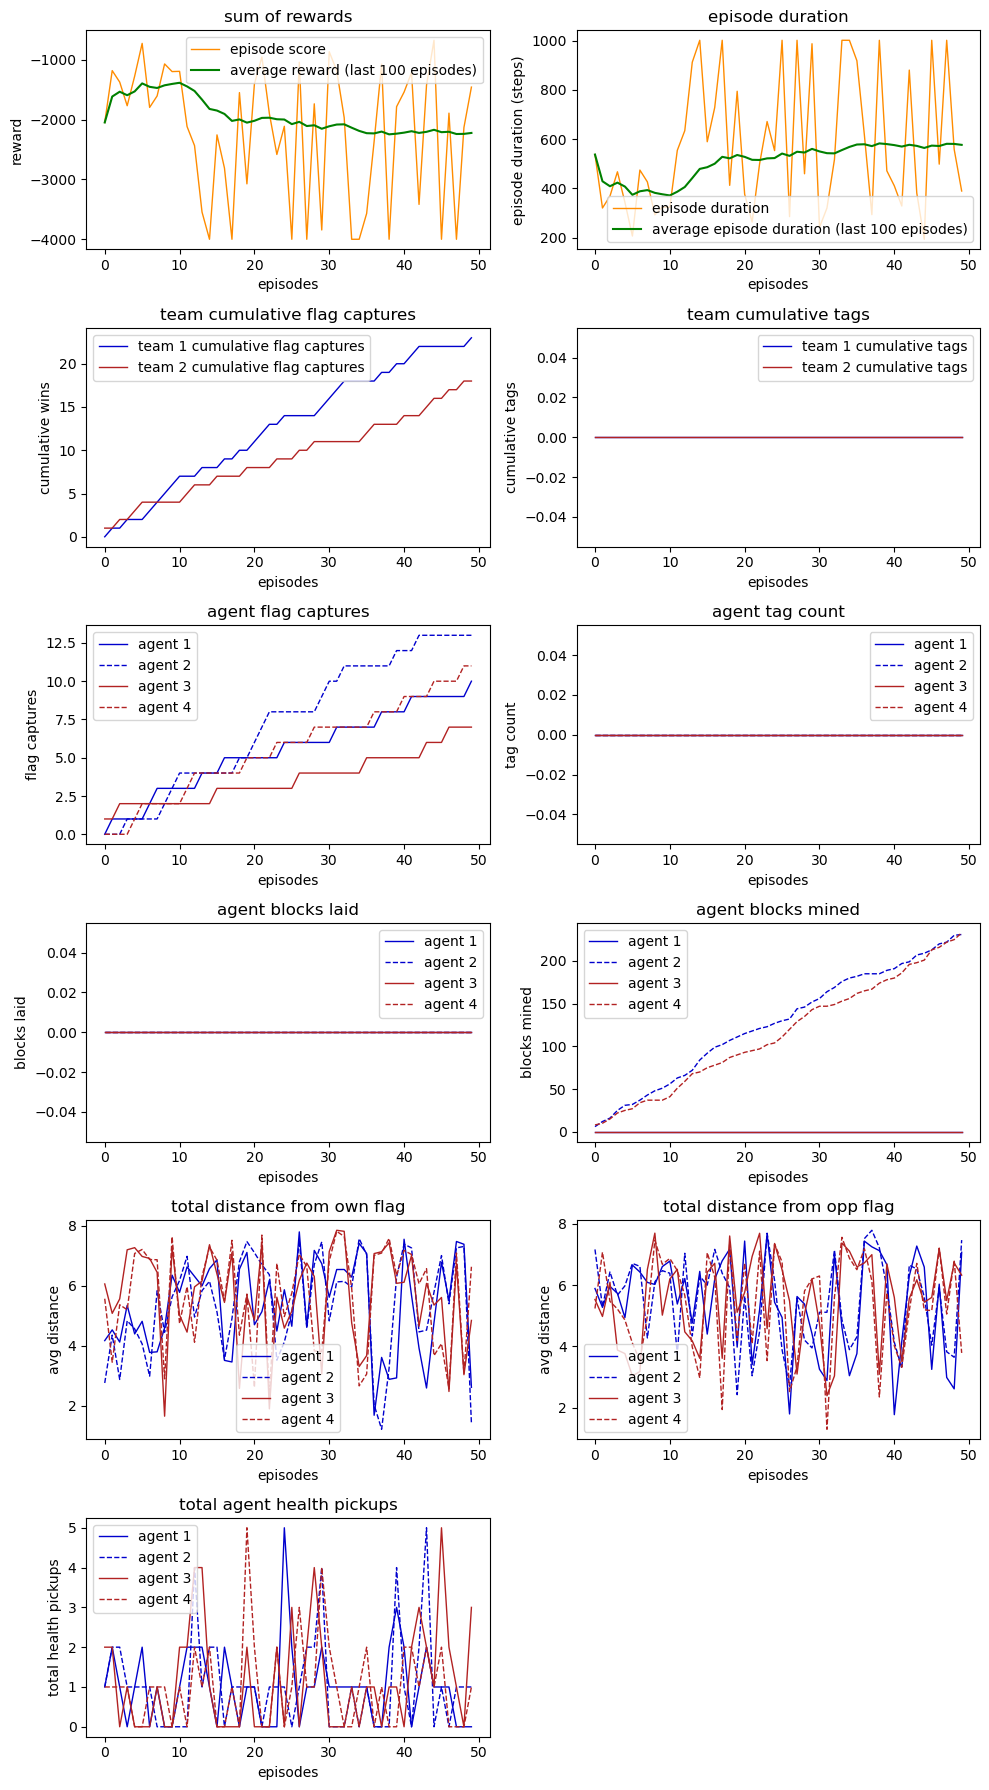

In [8]:
ut.plot_training_performance(training_metrics)

#### Inference

In [8]:
# create agents
use_softmax = True
agent_t1 = DQNAgent(name='dqn_t1',
                      use_softmax=use_softmax)

agent_t2 = DQNAgent(name='dqn_t2',
                      use_softmax=use_softmax)


In [11]:
# create environment
env = GridworldCtf(game_mode='random')
env.AGENT_TYPES = {
    0: 0,
    1: 2,
    2: 0,
    3: 2
}      
env_dims = (1, 1, 10, 10)


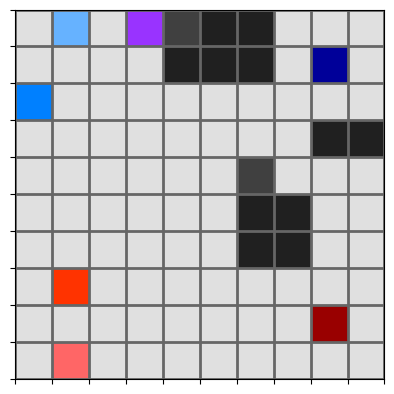

KeyboardInterrupt: 

In [12]:
# test model
ut.test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=100)

#### Interactive play with trained agents

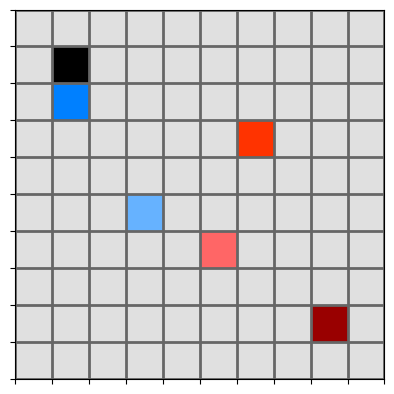

You win!, total score 141


In [12]:
env = GridworldCtf(game_mode='static')
env.play(player=0, agents=agents)